In [4]:
import numpy as np
import xarray as xr

import datetime as dt
import os
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
import re
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe

In [5]:
DATA_DIR = "/storage/elilouis/sublimationofsnow/"
DATES = pd.Series(['20230409', '20230410'])

# TOOLS

## SAIL Data

In [6]:
class FastData(object):
    data = None

class FastDataSAIL(FastData):
    @staticmethod
    def open_raw(files):
        files = sorted(files)
        high_rate_dfs = []
        for file in files:
            # Regular expression. extract date
            date = re.search(r"gucecorM1\.00\.(\d+)\.", file).group(1)
            df = pd.read_csv(file, skiprows=1, header=None).rename(
                    columns = dict(
                        zip(range(0,10), 
                        [
                            'Timestamp',
                            'u',
                            'v',
                            'w',
                            'windspeed units (M = m/s)',
                            'Speed of Sound',
                            'Status (00 means okay)',
                            'CO2 analog voltage output',
                            'H20 analog voltage output',
                            'Checksum',
                        ])
                    )
                )
            df['time'] = pd.to_datetime(
                f'{date} ' + df['Timestamp'].str[:-3],
                format="%Y%m%d %H:%M:%S.%f"
            )
            high_rate_dfs.append(df)
        return pd.concat(high_rate_dfs).set_index('time')
    
    @staticmethod
    def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df

# SAIL EC data

Open and wrangle the raw SAIL EC data

In [7]:
fast_data_files = DATES.apply(
    lambda date: glob.glob(
            os.path.join(
                DATA_DIR, 
                f"sail_fast_ecor_data/gucecorM1.00.{date}.000000.raw/**_sonic.raw"
            )
        )
).explode()
len(fast_data_files)

2

In [7]:
fast_df_sail = FastDataSAIL.open_raw(fast_data_files)
fast_df_sail = utils.modify_df_timezone(fast_df_sail.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_sail = fast_df_sail.loc['20230418']
fast_df_sail = fast_df_sail.sort_index()

TypeError: expected string or bytes-like object, got 'float'

Calculate 30-minute mean u, v, w, and 30-min wind direction, plot it

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

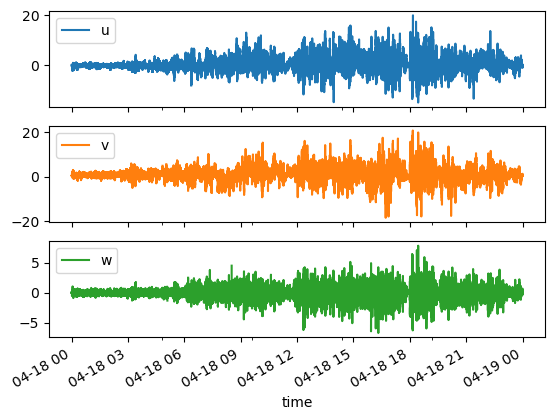

In [33]:
fast_df_sail[['u','v','w']].plot(subplots=True)

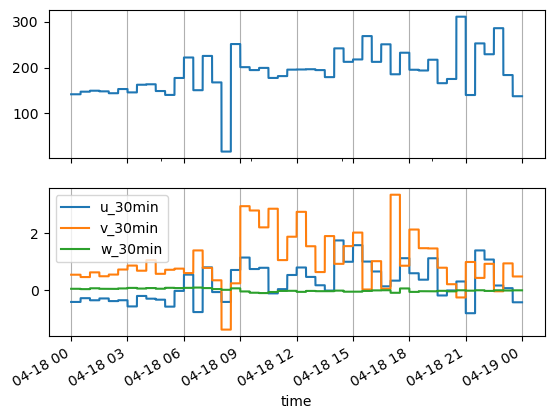

In [34]:
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sail['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_30min'], -fast_df_sail['v_30min']))
fast_df_sail['dir_30min'] = fast_df_sail['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)
fig, axes = plt.subplots(2,1)
fast_df_sail['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sail[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [35]:
fast_df_sail = fast_df_sail.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 0.6627422676363955 -1.3167491586164178e-16 0.044493535598934056
Means after 2nd rotation: 0.6642341364473263 -1.3167491586164178e-16 -7.359878427225912e-18
Means after 1st rotation: 0.8527944779328487 2.2164201298737846e-17 0.06441814672567406
Means after 2nd rotation: 0.8552240169805396 2.2164201298737846e-17 1.4683783360413824e-17
Means after 1st rotation: 0.3466228872077543 1.0515459396712361e-17 0.05392742845514919
Means after 2nd rotation: 0.3507928070471582 1.0515459396712361e-17 1.7810559353181563e-17
Means after 1st rotation: 2.340778295079225 -4.2385792184335753e-16 -0.06551576260135725
Means after 2nd rotation: 2.3416949719942695 -4.2385792184335753e-16 8.61287649065936e-18
Means after 1st rotation: 1.6936754260593072 4.093285852166126e-16 -0.044984477469368275
Means after 2nd rotation: 1.694272720682939 4.093285852166126e-16 2.4016728214240026e-17
Means after 1st rotation: 1.4580727311206618 -3.5211537085241e-16 -0.027027934806548706
Means after 2nd

In [36]:
fast_df_sail.index = fast_df_sail.index.get_level_values(1)

<Axes: xlabel='time'>

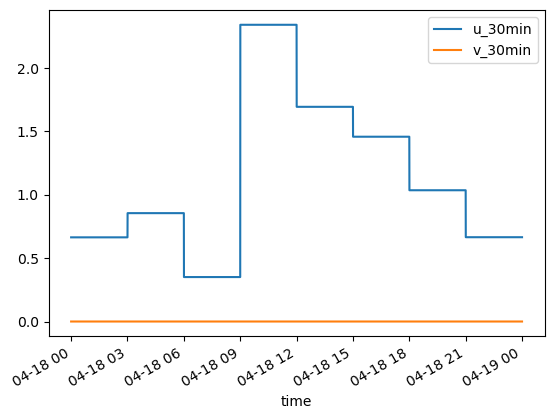

In [37]:
fast_df_sail.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
    'u': 'u_30min',
    'v': 'v_30min',
    'w': 'w_30min',
})[['u_30min', 'v_30min']].plot()

In [38]:
fast_df_sail['u'] = fast_df_sail['u'].interpolate()
fast_df_sail['v'] = fast_df_sail['v'].interpolate()
fast_df_sail['w'] = fast_df_sail['w'].interpolate()

Calculate MRD

In [39]:
mrd_uw_sail = fast_df_sail.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 109000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 109000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 5788.29it/s]


Got data of length 109969. using M = 16
Timestep of fast data is: 90.0 ms
Dataset of length 109969, with M = 16, permits 22 iterations.


100%|██████████| 22/22 [00:00<00:00, 6655.70it/s]


Got data of length 109006. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 109006, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 6815.26it/s]


Got data of length 108897. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108897, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 2754.75it/s]


Got data of length 108874. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108874, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 2982.34it/s]


Got data of length 108968. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108968, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 4988.41it/s]


Got data of length 108845. using M = 16
Timestep of fast data is: 70.0 ms
Dataset of length 108845, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 5883.01it/s]


Got data of length 108880. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108880, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 5731.41it/s]


In [40]:
mrd_uw_sail.hour_group = mrd_uw_sail.hour_group.str.replace('2023-04-18 ', '')

In [41]:
alt.Chart(mrd_uw_sail.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

alt.Chart(...)

# SPLASH EC data

In [30]:
fast_df_splash = xr.open_dataset(
    os.path.join(DATA_DIR, "splash_fast_asfs_data/sledwind10hz.asfs50.level2.0.20230418.000000.nc")
).to_dataframe().rename(columns={
    'metek_u': 'u',
    'metek_v': 'v',
    'metek_w': 'w',
})

In [31]:
fast_df_splash = utils.modify_df_timezone(fast_df_splash.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_splash = fast_df_splash.loc['20230418']

In [33]:
fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_splash['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_30min'], -fast_df_splash['v_30min']))
fast_df_splash['dir_30min'] = fast_df_splash['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

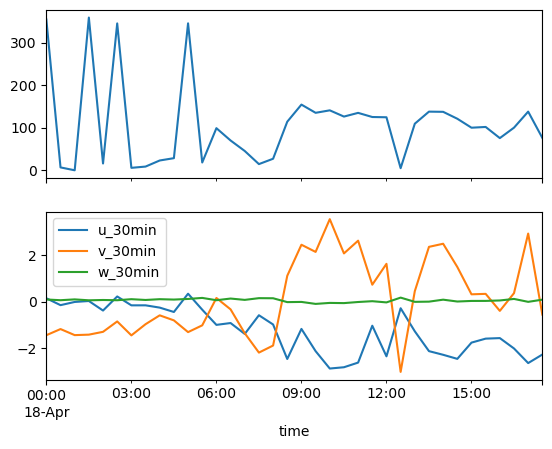

In [34]:
fast_df_splash_30min = fast_df_splash.groupby(pd.Grouper(freq='30min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_splash_30min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [35]:
fast_df_splash = fast_df_splash.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.2666482748900492 -1.098831888759114e-16 0.0772666142960887
Means after 2nd rotation: 1.2690027509689321 -1.098831888759114e-16 4.226276495227362e-18
Means after 1st rotation: 1.0324662924246089 -1.266705712775666e-17 0.11195183171403797
Means after 2nd rotation: 1.0385181065427538 -1.266705712775666e-17 -4.486249399413817e-18
Means after 1st rotation: 1.428171009464732 2.957019466981188e-17 0.09460395440404679
Means after 2nd rotation: 1.431300925893781 2.957019466981188e-17 -3.3530488598804544e-17
Means after 1st rotation: 3.0867025680330658 -3.801882171832956e-16 -0.03322424124510729
Means after 2nd rotation: 3.0868813702033053 -3.801882171832956e-16 -5.5444115005897276e-18
Means after 1st rotation: 2.0051384174349507 -1.689725409703536e-16 0.04083325582150301
Means after 2nd rotation: 2.0055541448324257 -1.689725409703536e-16 2.125357741892729e-17
Means after 1st rotation: 2.031915953893763 -1.6052391392183592e-16 0.05477563106018458
Means after 2nd rotat

In [36]:
fast_df_splash.index = fast_df_splash.index.get_level_values(1)

In [37]:
fast_df_splash['u'] = fast_df_splash['u'].interpolate()
fast_df_splash['v'] = fast_df_splash['v'].interpolate()
fast_df_splash['w'] = fast_df_splash['w'].interpolate()

Calculate MRD

In [38]:
mrd_uw_splash = fast_df_splash.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 40.36it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 6295.50it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 6845.45it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 5792.86it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 7069.62it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 6636.56it/s]


In [39]:
mrd_uw_splash.hour_group = mrd_uw_splash.hour_group.str.replace('2023-04-18 ', '')

In [40]:
alt.Chart(mrd_uw_splash.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

alt.Chart(...)

# SOS EC data

Open data, average from 20hz to 10hz

In [52]:
fast_df_sos = fast_data_files_to_dataframe(glob.glob(
                os.path.join(DATA_DIR, 'sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230409_**.nc')
        ), 
        rotation='none'
)

In [53]:
fast_df_sos = fast_df_sos.set_index('time').loc['20230409']

In [54]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='100ms')).mean()

In [55]:
fast_df_sos = fast_df_sos[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

In [ ]:
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sos['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_30min'], -fast_df_sos['v_30min']))
fast_df_sos['dir_30min'] = fast_df_sos['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

KeyError: 'dir_30min'

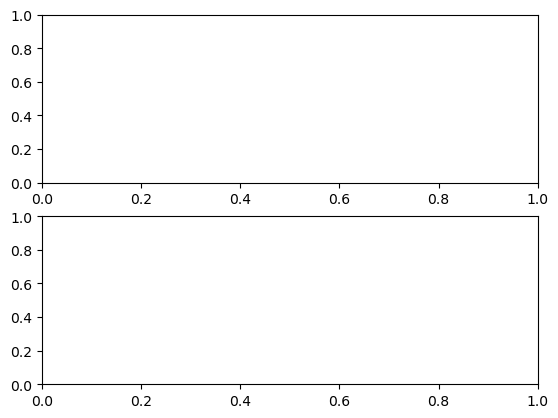

In [50]:
fast_df_sos_30min = fast_df_sos.groupby(pd.Grouper(freq='30min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_sos_30min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sos_30min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [16]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 2.1524296 -1.4919705e-07 -0.0020802
Means after 2nd rotation: 2.1524305 -1.4919705e-07 -8.388802e-10
Means after 1st rotation: 2.2265575 -7.233796e-08 -0.00865916
Means after 2nd rotation: 2.2265744 -7.233796e-08 3.1568386e-09
Means after 1st rotation: 1.9743581 1.7462837e-07 -0.005884919
Means after 2nd rotation: 1.9743667 1.7462837e-07 -7.064254e-11
Means after 1st rotation: 1.7387094 -4.7471787e-08 -0.003146507
Means after 2nd rotation: 1.7387122 -4.7471787e-08 4.2385526e-10
Means after 1st rotation: 1.3565068 1.6276041e-07 -0.0007503071
Means after 2nd rotation: 1.356507 1.6276041e-07 -3.5100514e-10
Means after 1st rotation: 1.5419699 1.4467592e-07 -0.00807572
Means after 2nd rotation: 1.5419912 1.4467592e-07 2.1192763e-10
Means after 1st rotation: 3.9456747 1.6276041e-07 -0.020161524
Means after 2nd rotation: 3.9457262 1.6276041e-07 3.1789144e-10
Means after 1st rotation: 5.622295 2.7691877e-08 -0.029910304
Means after 2nd rotation: 5.6223755 2.7691877e-0

In [17]:
fast_df_sos.index = fast_df_sos.index.get_level_values(1)

In [18]:
fast_df_sos['u'] = fast_df_sos['u'].interpolate()
fast_df_sos['v'] = fast_df_sos['v'].interpolate()
fast_df_sos['w'] = fast_df_sos['w'].interpolate()

Calculate MRD

In [19]:
mrd_uw_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 41.73it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 4533.92it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 2577.41it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 6861.98it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 5335.29it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 2636.66it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 5454.91it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 5308.61it/s]


In [20]:
mrd_uw_sos.hour_group = mrd_uw_sos.hour_group.str.replace('2023-04-09 ', '')

In [21]:
alt.Chart(mrd_uw_sos.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

alt.Chart(...)